#  **Import the required Library and Packages**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import pickle
from skimage.transform import rescale, resize
from sklearn.utils import class_weight
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
from sklearn.metrics import  classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import plot_roc_curve

In [2]:
import warnings
warnings.filterwarnings("ignore")

# **Preprocessing** 

> # **File Handling**

In [3]:
def get_filename(part,train=True):
    root='../input/mura-v11/'
    if train:
        csv_path="../input/mura-v11/MURA-v1.1/train_image_paths.csv"
    else:
        csv_path="../input/mura-v11/MURA-v1.1/valid_image_paths.csv"
    
    with open(csv_path, 'rb') as F:
        d = F.readlines()
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d]  
        else:
            imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]

    #imgs= [x.replace("/", "\\") for x in imgs]
    labels= [x.split('_')[-1].split('/')[0] for x in imgs]
    return imgs,labels


#To icrop a image from center
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


> # **Data Augmentation**

In [4]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate, Resize
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
])
AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=255)
])

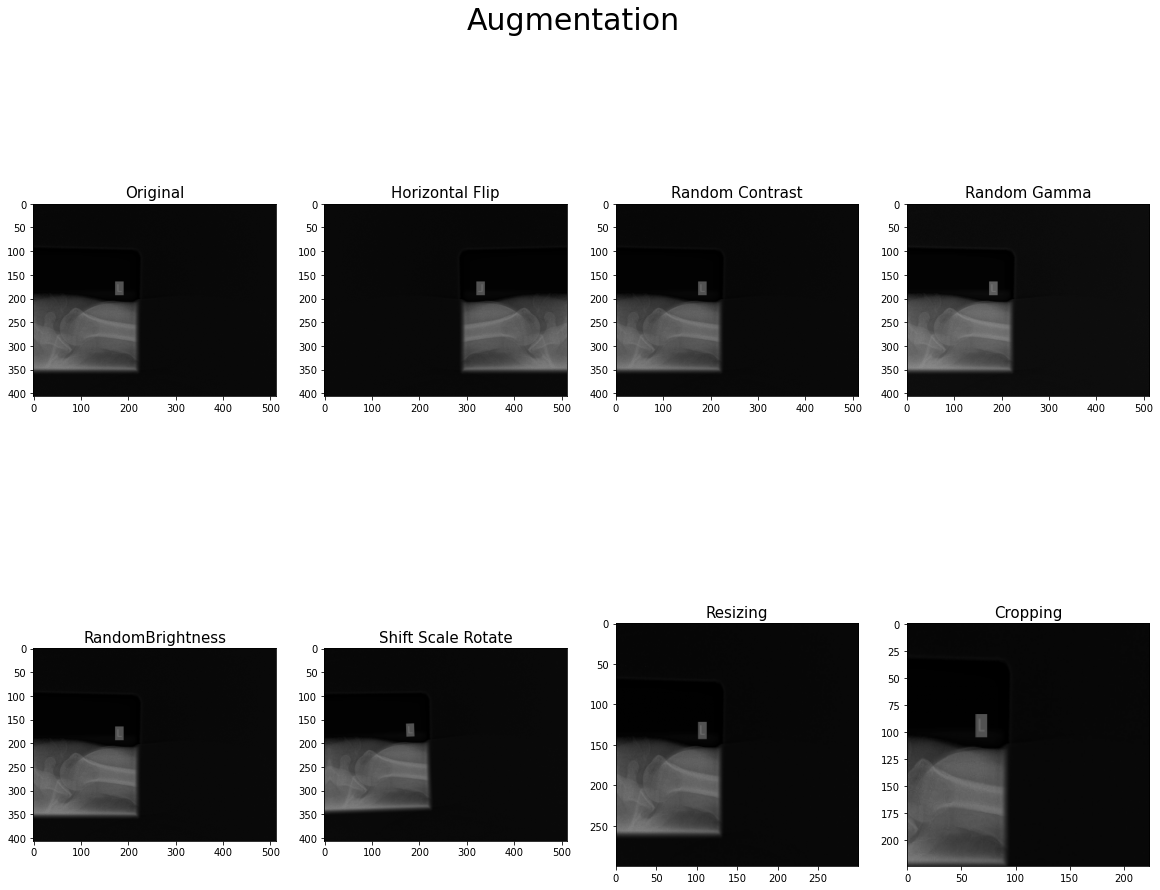

In [7]:
albumentation_list =  [
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
]
root='../input/'
chosen_image= imread(root+'mura-v11/MURA-v1.1/train/XR_SHOULDER/patient01055/study1_positive/image3.png')
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)
img_matrix_list = img_matrix_list[:-1]  
img= resize(chosen_image,(300,300,3))
img_matrix_list.append(img)
img_matrix_list.append(crop_center(img,224,224))

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","Horizontal Flip","Random Contrast","Random Gamma","RandomBrightness",
               "Shift Scale Rotate","Resizing", "Cropping"]

def plot_img(img_matrix_list, title_list, ncols, main_title="Augmentation"):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
    fig.suptitle(main_title, fontsize = 30)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()
    
plot_img(img_matrix_list, titles_list, ncols = 4)

> # **Data Generator** 

In [8]:
class Data_Generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size,transform) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.t= transform
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    x=[]
    for file in batch_x:
        img= imread(file)
        img= self.t(image=img)["image"]
        img= resize(img,(300,300,3))
        img= crop_center(img,224,224)
        x.append(img)
    x=np.array(x)/255.0
    y= np.array(batch_y)
    return x,y

In [9]:
part='XR_SHOULDER'
imgs,labels= get_filename(part=part)
val_imgs,val_labels= get_filename(part=part,train=False)
print(labels.count('positive'),labels.count('negative'))
training_data= labels.count('positive')+labels.count('negative')
print("Training Data: ", training_data)
train_y_data= [0 if x=='positive' else 1 for x in labels]
train_y_data= keras.utils.to_categorical(train_y_data)
print(val_labels.count('positive'),val_labels.count('negative'))
validation_data= val_labels.count('positive')+val_labels.count('negative')
print("Validation Data: ", validation_data)
val_y_data= [0 if x=='positive' else 1 for x in val_labels]
val_y_data= keras.utils.to_categorical(val_y_data)

4168 4211
Training Data:  8379
278 285
Validation Data:  563


In [10]:
from sklearn.utils.class_weight import compute_class_weight

y_int = np.argmax(train_y_data, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_int), y_int)
d_class_weights = dict(enumerate(class_weights))

**Training and Validation Data Generators**

In [11]:
batch_size = 32
imgs, train_y_data = shuffle(imgs, train_y_data)
training_batch_gen = Data_Generator(imgs, train_y_data, batch_size,AUGMENTATIONS_TRAIN)
validation_batch_gen = Data_Generator(val_imgs, val_y_data, batch_size,AUGMENTATIONS_TEST)

> # **Model Building**

> # **Resnet34**

In [12]:
! pip install git+https://github.com/qubvel/classification_models.git
from classification_models.keras import Classifiers

  Cloning https://github.com/qubvel/classification_models.git to c:\users\acer\appdata\local\temp\pip-req-build-bq1zrwus


  Running command git clone -q https://github.com/qubvel/classification_models.git 'C:\Users\Acer\AppData\Local\Temp\pip-req-build-bq1zrwus'
  Running command git submodule update --init --recursive -q


In [13]:
ResNet34, _ = Classifiers.get('resnet34')


resnet34 = ResNet34(input_shape=(224,224,3), weights='imagenet', include_top=False)
input_image=keras.layers.Input((224,224,3))
x= resnet34(input_image)

x=keras.layers.Flatten()(x)
x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 7, 7, 512)         21302473  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                

In [14]:
history=model.fit_generator(generator=training_batch_gen,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 5,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = validation_batch_gen,
                   validation_steps = int(validation_data // batch_size),
                           )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
159/261 [=================>............] - ETA: 12:25 - loss: 0.9463 - accuracy: 0.6295

KeyboardInterrupt: 

In [31]:
y_pred=  model.predict(validation_batch_gen)
y_pred = np.argmax(y_pred,axis = 1)
y_act = np.argmax(val_y_data,axis = 1)

In [32]:
print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.07      0.13       278
           1       0.52      0.98      0.68       285

    accuracy                           0.53       563
   macro avg       0.66      0.53      0.41       563
weighted avg       0.66      0.53      0.41       563



In [33]:
metrics.cohen_kappa_score(y_act,y_pred)

0.055013434255116844

In [34]:
confusion_matrix(y_act,y_pred)

array([[ 20, 258],
       [  5, 280]])

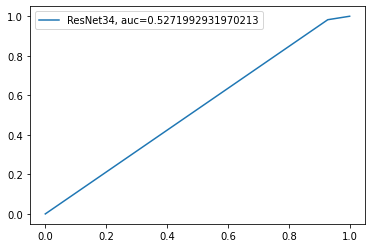

In [35]:
fpr, tpr, thresh = metrics.roc_curve(y_act,y_pred)
auc = metrics.roc_auc_score(y_act,y_pred)
plt.plot(fpr,tpr,label="ResNet34, auc="+str(auc))
plt.legend()

> # **DenseNet121**

In [15]:
dn121=keras.applications.DenseNet121(include_top=False,input_shape=(224,224,3))
input_image=keras.layers.Input((224,224,3))
x= dn121(input_image)

x=keras.layers.Flatten()(x)
x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               12845312  
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [16]:
history=model.fit_generator(generator=training_batch_gen,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 5,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = validation_batch_gen,
                   validation_steps = int(validation_data // batch_size),
                           )

Epoch 1/5
 33/261 [==>...........................] - ETA: 59:11 - loss: 2.2057 - accuracy: 0.5341

KeyboardInterrupt: 

In [38]:
y_pred=  model.predict(validation_batch_gen)
y_pred = np.argmax(y_pred,axis = 1)
y_act = np.argmax(val_y_data,axis = 1)

In [39]:
print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72       278
           1       0.73      0.72      0.72       285

    accuracy                           0.72       563
   macro avg       0.72      0.72      0.72       563
weighted avg       0.72      0.72      0.72       563



In [40]:
metrics.cohen_kappa_score(y_act,y_pred)

0.44231048298053566

In [41]:
confusion_matrix(y_act,y_pred)

array([[202,  76],
       [ 81, 204]])

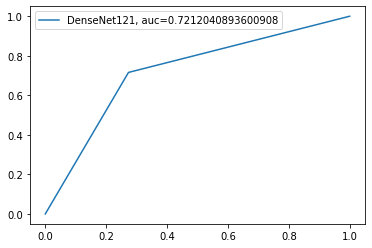

In [42]:
fpr, tpr, thresh = metrics.roc_curve(y_act,y_pred)
auc = metrics.roc_auc_score(y_act,y_pred)
plt.plot(fpr,tpr,label="DenseNet121, auc="+str(auc))
plt.legend()

> # **EfficientNetB0**

In [43]:
import tensorflow
effb0=tensorflow.keras.applications.EfficientNetB0(include_top=False,input_shape=(224,224,3))
input_image=keras.layers.Input((224,224,3))
x= effb0(input_image)

x=keras.layers.Flatten()(x)
x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

16711680/16705208 [==============================] - 0s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
flatten_2 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16056576  
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
____________________________________________________________

In [44]:
history=model.fit_generator(generator=training_batch_gen,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 5,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = validation_batch_gen,
                   validation_steps = int(validation_data // batch_size),
                           )

Epoch 1/5
261/261 [==============================] - 449s 2s/step - loss: 1.1834 - accuracy: 0.4985 - val_loss: 0.9018 - val_accuracy: 0.4890
Epoch 2/5
261/261 [==============================] - 433s 2s/step - loss: 0.7226 - accuracy: 0.5274 - val_loss: 247.7758 - val_accuracy: 0.5110
Epoch 3/5
261/261 [==============================] - 432s 2s/step - loss: 0.6964 - accuracy: 0.5486 - val_loss: 432.7915 - val_accuracy: 0.5110
Epoch 4/5
261/261 [==============================] - 432s 2s/step - loss: 0.6875 - accuracy: 0.5700 - val_loss: 7811518.5000 - val_accuracy: 0.5110
Epoch 5/5
261/261 [==============================] - 431s 2s/step - loss: 0.6761 - accuracy: 0.5933 - val_loss: 0.6964 - val_accuracy: 0.5110


In [45]:
y_pred=  model.predict(validation_batch_gen)
y_pred = np.argmax(y_pred,axis = 1)
y_act = np.argmax(val_y_data,axis = 1)

In [46]:
print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66       278
           1       0.00      0.00      0.00       285

    accuracy                           0.49       563
   macro avg       0.25      0.50      0.33       563
weighted avg       0.24      0.49      0.33       563



In [47]:
metrics.cohen_kappa_score(y_act,y_pred)

0.0

In [48]:
confusion_matrix(y_act,y_pred)

array([[278,   0],
       [285,   0]])

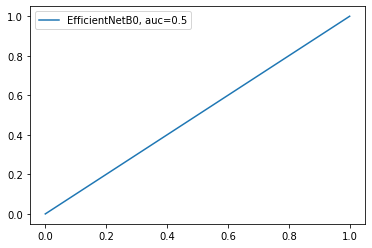

In [49]:
fpr, tpr, thresh = metrics.roc_curve(y_act,y_pred)
auc = metrics.roc_auc_score(y_act,y_pred)
plt.plot(fpr,tpr,label="EfficientNetB0, auc="+str(auc))
plt.legend()

> # **ResNet50**

In [34]:

res50=keras.applications.ResNet50(include_top=False,input_shape=(224,224,3))
input_image=keras.layers.Input((224,224,3))
x= res50(input_image)

x=keras.layers.Flatten()(x)
x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

94773248/94765736 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25690368  
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
____________________________________________________________

In [35]:
history=model.fit_generator(generator=training_batch_gen,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 5,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = validation_batch_gen,
                   validation_steps = int(validation_data // batch_size),
                           )

Epoch 1/5
261/261 [==============================] - 448s 2s/step - loss: 1.7363 - accuracy: 0.6015 - val_loss: 1.0141 - val_accuracy: 0.4890
Epoch 2/5
261/261 [==============================] - 439s 2s/step - loss: 0.6930 - accuracy: 0.6933 - val_loss: 0.8864 - val_accuracy: 0.4890
Epoch 3/5
261/261 [==============================] - 441s 2s/step - loss: 0.6357 - accuracy: 0.7243 - val_loss: 1.2469 - val_accuracy: 0.4890
Epoch 4/5
261/261 [==============================] - 452s 2s/step - loss: 0.5773 - accuracy: 0.7369 - val_loss: 0.8194 - val_accuracy: 0.4890
Epoch 5/5
261/261 [==============================] - 452s 2s/step - loss: 0.5658 - accuracy: 0.7478 - val_loss: 0.7865 - val_accuracy: 0.4963


In [36]:
y_pred=  model.predict(validation_batch_gen)
y_pred = np.argmax(y_pred,axis = 1)
y_act = np.argmax(val_y_data,axis = 1)

In [37]:
print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

           0       0.64      0.03      0.05       278
           1       0.51      0.99      0.67       285

    accuracy                           0.51       563
   macro avg       0.57      0.51      0.36       563
weighted avg       0.57      0.51      0.36       563



In [38]:
metrics.cohen_kappa_score(y_act,y_pred)

0.01127778735687246

In [39]:
confusion_matrix(y_act,y_pred)

array([[  7, 271],
       [  4, 281]])

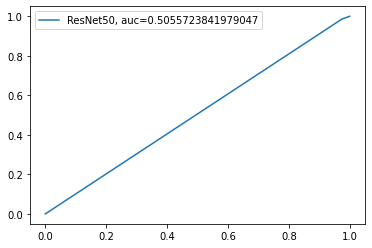

In [40]:
fpr, tpr, thresh = metrics.roc_curve(y_act,y_pred)
auc = metrics.roc_auc_score(y_act,y_pred)
plt.plot(fpr,tpr,label="ResNet50, auc="+str(auc))
plt.legend()

> # **MobilNet**

In [41]:

Mn=keras.applications.MobileNet(include_top=False,input_shape=(224,224,3))
input_image=keras.layers.Input((224,224,3))
x=Mn (input_image)

x=keras.layers.Flatten()(x)
x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model_mn=keras.Model(inputs=input_image,outputs=out)
model_mn.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

17227776/17225924 [==============================] - 0s 0us/step
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               25690368  
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
____________________________________________________________

In [42]:
history=model_mn.fit_generator(generator=training_batch_gen,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 5,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = validation_batch_gen,
                   validation_steps = int(validation_data // batch_size),
                           )

Epoch 1/5
261/261 [==============================] - 447s 2s/step - loss: 1.4072 - accuracy: 0.5842 - val_loss: 0.7978 - val_accuracy: 0.4890
Epoch 2/5
261/261 [==============================] - 440s 2s/step - loss: 0.6282 - accuracy: 0.6761 - val_loss: 0.6121 - val_accuracy: 0.6452
Epoch 3/5
261/261 [==============================] - 440s 2s/step - loss: 0.5881 - accuracy: 0.7078 - val_loss: 0.5651 - val_accuracy: 0.7114
Epoch 4/5
261/261 [==============================] - 431s 2s/step - loss: 0.5633 - accuracy: 0.7393 - val_loss: 0.6772 - val_accuracy: 0.6985
Epoch 5/5
261/261 [==============================] - 432s 2s/step - loss: 0.5341 - accuracy: 0.7505 - val_loss: 0.6217 - val_accuracy: 0.7224


In [43]:
y_pred_mn=  model_mn.predict(validation_batch_gen)
y_pred = np.argmax(y_pred_mn,axis = 1)
y_act = np.argmax(val_y_data,axis = 1)

In [44]:
print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.60      0.69       278
           1       0.69      0.85      0.76       285

    accuracy                           0.73       563
   macro avg       0.74      0.73      0.72       563
weighted avg       0.74      0.73      0.72       563



In [45]:
metrics.cohen_kappa_score(y_act,y_pred)

0.45478539916830707

In [46]:
confusion_matrix(y_act,y_pred)

array([[168, 110],
       [ 43, 242]])

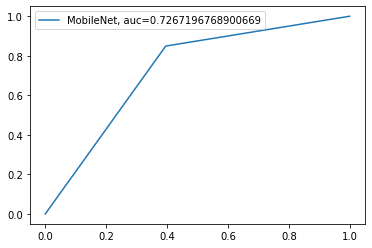

In [47]:
fpr, tpr, thresh = metrics.roc_curve(y_act,y_pred)
auc = metrics.roc_auc_score(y_act,y_pred)
plt.plot(fpr,tpr,label="MobileNet, auc="+str(auc))
plt.legend()

> # **ResNet50V2**

In [48]:

RNV2=keras.applications.ResNet50V2(include_top=False,input_shape=(224,224,3))
input_image=keras.layers.Input((224,224,3))
x=RNV2(input_image)

x=keras.layers.Flatten()(x)
x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model_rnv2=keras.Model(inputs=input_image,outputs=out)
model_rnv2.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(model_rnv2.summary())

94674944/94668760 [==============================] - 1s 0us/step
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten_5 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               25690368  
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
____________________________________________________________

In [49]:
history=model_rnv2.fit_generator(generator=training_batch_gen,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 5,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = validation_batch_gen,
                   validation_steps = int(validation_data // batch_size),
                           )

Epoch 1/5
261/261 [==============================] - 447s 2s/step - loss: 1.0422 - accuracy: 0.5902 - val_loss: 0.8281 - val_accuracy: 0.4890
Epoch 2/5
261/261 [==============================] - 438s 2s/step - loss: 0.6351 - accuracy: 0.6726 - val_loss: 0.8533 - val_accuracy: 0.4871
Epoch 3/5
261/261 [==============================] - 439s 2s/step - loss: 0.5943 - accuracy: 0.7308 - val_loss: 1.0966 - val_accuracy: 0.6360
Epoch 4/5
261/261 [==============================] - 438s 2s/step - loss: 0.5791 - accuracy: 0.7344 - val_loss: 1.3413 - val_accuracy: 0.6710
Epoch 5/5
261/261 [==============================] - 446s 2s/step - loss: 0.5392 - accuracy: 0.7516 - val_loss: 0.9747 - val_accuracy: 0.6029


In [50]:
y_pred_rnv2=  model_rnv2.predict(validation_batch_gen)
y_pred_rnv2 = np.argmax(y_pred_rnv2,axis = 1)
y_act = np.argmax(val_y_data,axis = 1)

In [51]:
print(classification_report(y_act,y_pred_rnv2))

              precision    recall  f1-score   support

           0       0.58      0.70      0.64       278
           1       0.64      0.52      0.57       285

    accuracy                           0.61       563
   macro avg       0.61      0.61      0.60       563
weighted avg       0.61      0.61      0.60       563



In [52]:
metrics.cohen_kappa_score(y_act,y_pred_rnv2)

0.21312280436671327

In [53]:
confusion_matrix(y_act,y_pred_rnv2)

array([[194,  84],
       [138, 147]])

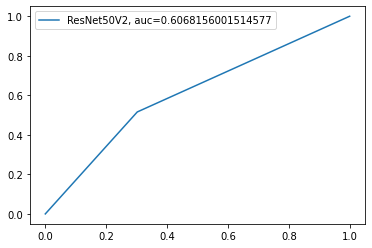

In [54]:
fpr, tpr, thresh = metrics.roc_curve(y_act,y_pred_rnv2)
auc = metrics.roc_auc_score(y_act,y_pred_rnv2)
plt.plot(fpr,tpr,label="ResNet50V2, auc="+str(auc))
plt.legend()

> # **Multi-Model**

**Here three different models are stacked together, Models used here are Xception,ResNet50V2 and MobileNet. All Layers of Xception are trained for the following training process and rest models layers are freezed.**

In [55]:
input_image=keras.layers.Input((224,224,3))

Xception = tf.keras.applications.Xception(input_tensor=input_image, weights='imagenet', include_top=False)       
for layer in Xception.layers:
    #layer.trainable = False
    layer._name = layer.name + str('_1')
    
MN = tf.keras.applications.MobileNet(input_tensor=input_image, weights='imagenet', include_top=False)       
for layer in MN.layers:
    layer.trainable = False
    layer._name = layer.name + str('_2')    
    

RNV2 = tf.keras.applications.ResNet50V2(input_tensor=input_image, weights='imagenet', include_top=False)       
for layer in RNV2.layers:
    layer.trainable = False
    layer._name = layer.name + str('_3')
    
concat_Output = tf.keras.layers.Concatenate()([Xception.output,MN.output,RNV2.output])

x=keras.layers.Flatten()(concat_Output)
x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

83689472/83683744 [==============================] - 0s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12_1_2_3 (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad_3 (ZeroPadding2D)     (None, 230, 230, 3)  0           input_12_1_2_3[0][0]             
__________________________________________________________________________________________________
conv1_conv_3 (Conv2D)           (None, 112, 112, 64) 9472        conv1_pad_3[0][0]                
__________________________________________________________________________________________________
pool1_pad_3 (ZeroPadding2D)     (None, 114, 114, 64) 0           conv1_conv_3[0][0]               
___________________________

> # **Train the Model**

In [63]:
history=model.fit_generator(generator=training_batch_gen,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 5,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = validation_batch_gen,
                   validation_steps = int(validation_data // batch_size),
                           )

Epoch 1/5
261/261 [==============================] - 456s 2s/step - loss: 0.4256 - accuracy: 0.8236 - val_loss: 1.7273 - val_accuracy: 0.7812
Epoch 2/5
261/261 [==============================] - 456s 2s/step - loss: 0.3909 - accuracy: 0.8293 - val_loss: 2.5505 - val_accuracy: 0.7978
Epoch 3/5
261/261 [==============================] - 457s 2s/step - loss: 0.3714 - accuracy: 0.8441 - val_loss: 3.5052 - val_accuracy: 0.7721
Epoch 4/5
261/261 [==============================] - 451s 2s/step - loss: 0.3507 - accuracy: 0.8603 - val_loss: 2.9703 - val_accuracy: 0.7960
Epoch 5/5
261/261 [==============================] - 458s 2s/step - loss: 0.3395 - accuracy: 0.8625 - val_loss: 3.0689 - val_accuracy: 0.7739


> # **Evaluation**

In [64]:
y_pred=  model.predict(validation_batch_gen)
y_pred = np.argmax(y_pred,axis = 1)
y_act = np.argmax(val_y_data,axis = 1)

**Classification Report**

In [65]:
print(classification_report(y_act,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.64      0.74       278
           1       0.72      0.92      0.81       285

    accuracy                           0.78       563
   macro avg       0.80      0.78      0.78       563
weighted avg       0.80      0.78      0.78       563



**Cohen Kappa**

In [66]:
metrics.cohen_kappa_score(y_act,y_pred)

0.5614959378423389

**Confusion Matrix**

In [67]:
confusion_matrix(y_act,y_pred)

array([[178, 100],
       [ 23, 262]])

**Roc-Auc Curve**

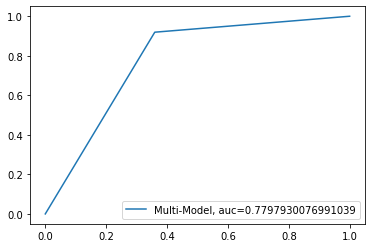

In [68]:
fpr, tpr, thresh = metrics.roc_curve(y_act,y_pred)
auc = metrics.roc_auc_score(y_act,y_pred)
plt.plot(fpr,tpr,label="Multi-Model, auc="+str(auc))
plt.legend()

In [1]:
models = ['ResNet34', 'DenseNet121', 'EfficientNetB0','ResNet50',' MobilNet', 'ResNet50V2','Ensemble Model']
Train_acc = [0.7690,0.7667, 0.5933,0.7478, 0.7505,0.7516, 0.8603]
Val_acc = [0.5165,0.7169, 0.5110, 0.4963, 0.7224, 0.6029,0.7739]

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

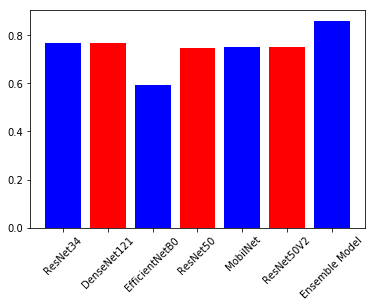

In [12]:
## Training Accuracy Plot
import matplotlib.pyplot as plt
plt.bar(models,Train_acc,color=['blue','red'])
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text xticklabel objects>)

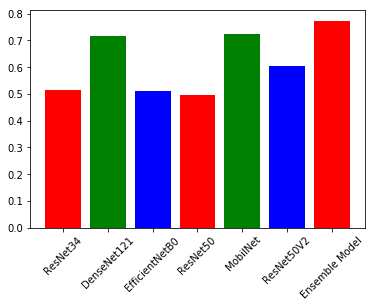

In [9]:
plt.bar(models,Val_acc,color=['Red','Green','Blue'])
plt.xticks(rotation=45)

In [8]:
plt.xticks?